In [1]:
%load_ext autoreload
%autoreload 2

# Config

In [2]:
from icehockey_rules.config import get_config

config = get_config()

# Data

## Transcribed Rulebook

### Load Data
(from yaml to a Python dictionary)

In [3]:
from icehockey_rules.rulebook import get_rulebooks, __version__ as parsing_version

rulebooks = get_rulebooks()
iihf_rulebook = rulebooks["iihf"]

### Assert All Ids Unique

In [4]:
ids = []
for rule in iihf_rulebook["rules"]:
    if "situation" in rule:
        for situation in rule["situation"]:
            ids.append(situation["number"])

    for subsection in rule["subsections"]:
        ids.append(subsection["number"])
        
assert len(ids) == len(set(ids))

### Table Form (Pandas)
Example of sections and situations for rule 8

#### Situations

<Axes: >

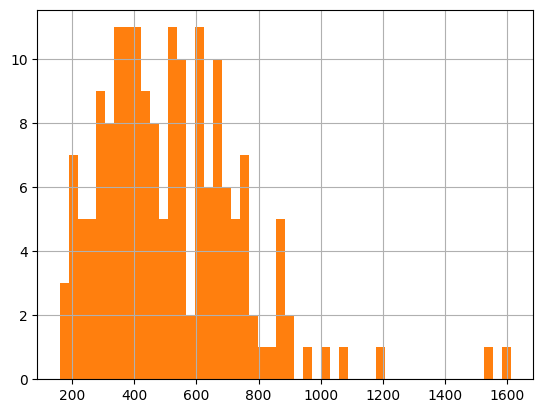

In [5]:
from icehockey_rules.rulebook import get_iihf_situations_df

iihf_situations_df = get_iihf_situations_df()
iihf_situations_df.char_count.hist(bins=50)

#### Subsections

<Axes: >

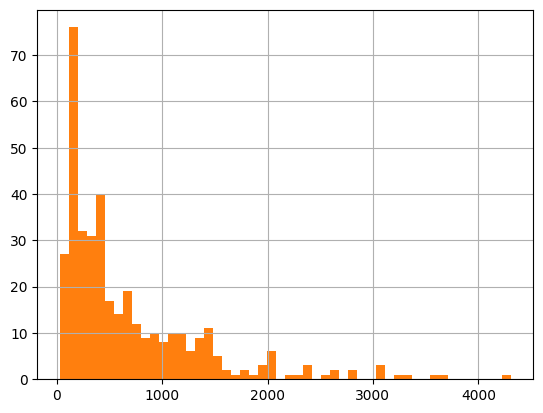

In [6]:
from icehockey_rules.rulebook import get_iihf_subsections_df

iihf_subsections_df = get_iihf_subsections_df()
iihf_subsections_df.char_count.hist(bins=50)

## Rule and Situation Chunks

The plan is to chunk rules by their subsections and casebook situations.  If any one of these chunks is still too big (say more than 300 characters), then further chunk into 300 character segments.

In [7]:
from icehockey_rules.rulebook import get_chunked_iihf_rulebook_records

chunked_iihf_rulebook_records = get_chunked_iihf_rulebook_records(iihf_rulebook)
len(chunked_iihf_rulebook_records)

1126

In [8]:
[record["id"] for record in chunked_iihf_rulebook_records][:10]

['1.1-0',
 '1.1-1',
 '1.2',
 '1.3-0',
 '1.3-1',
 '1.3-2',
 '1.4-0',
 '1.4-1',
 '1.5-0',
 '1.5-1']

## Chunk Embeddings

### Model

In [9]:
from dotenv import load_dotenv
_ = load_dotenv()

In [10]:
from openai import OpenAI

openai_client = OpenAI()

### Embed Rulebook and Persist (or Load)

In [11]:
NAME = f"rulebook--{parsing_version}--{config.embedder.model}"
RE_EMBED = False
NAME

'rulebook--v1--text-embedding-3-small'

In [12]:
from pathlib import Path
import pickle
from copy import deepcopy

chunked_iihf_rulebook_embedding_filepath = Path(f"../data/{NAME}-embeddings.p")

if chunked_iihf_rulebook_embedding_filepath.exists() and not RE_EMBED:
    with chunked_iihf_rulebook_embedding_filepath.open("rb") as f:
        chunked_iihf_rulebook_embeddings = pickle.load(f)

    # Ensure everything besides values are valid
    assert len(chunked_iihf_rulebook_embeddings) == len(chunked_iihf_rulebook_records)
        
else:
    chunked_iihf_rulebook_embeddings = [
        dict(
            id=chunk_record["id"],
            values=embedding_obj.embedding 
        )
        for embedding_obj, chunk_record in zip(
            openai_client.embeddings.create(
                input=[
                    chunk_record["metadata"]["text"]
                    for chunk_record in chunked_iihf_rulebook_records
                ],
                model=config.embedder.model
            ).data,
            chunked_iihf_rulebook_records
        )
    ]

    with chunked_iihf_rulebook_embedding_filepath.open("wb") as f:
        pickle.dump(chunked_iihf_rulebook_embeddings, f)

    with chunked_iihf_rulebook_embedding_filepath.open("rb") as f:
        chunked_iihf_rulebook_embeddings_test = pickle.load(f)
    
    assert chunked_iihf_rulebook_embeddings == chunked_iihf_rulebook_embeddings_test

In [13]:
    with chunked_iihf_rulebook_embedding_filepath.open("wb") as f:
        pickle.dump(chunked_iihf_rulebook_embeddings, f)

In [14]:
embedding_dim = len(chunked_iihf_rulebook_embeddings[0]['values'])
embedding_dim

1536

# Vector Database

## Pinecone

In [15]:
import os
from pinecone.grpc import PineconeGRPC as Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
pinecone_api_key = os.getenv("PINECONE_API_KEY") or "PINECONE_API_KEY"

pinecone_client = Pinecone(api_key=pinecone_api_key)
pinecone_client.list_indexes()

{'indexes': [{'dimension': 1536,
              'host': 'canopy--iihf-rulebook-7748f17.svc.gcp-starter.pinecone.io',
              'metric': 'cosine',
              'name': 'canopy--iihf-rulebook',
              'spec': {'pod': {'environment': 'gcp-starter',
                               'pod_type': 'starter',
                               'pods': 1,
                               'replicas': 1,
                               'shards': 1}},
              'status': {'ready': True, 'state': 'Ready'}},
             {'dimension': 1536,
              'host': 'rulebook--v1--text-embedding-3-small-7748f17.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'rulebook--v1--text-embedding-3-small',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

### Create Index

In [16]:
from pinecone import ServerlessSpec
from icehockey_rules.retrieve import INDEX_NAME, PINECONE_INDEX


if INDEX_NAME not in [index["name"] for index in pinecone_client.list_indexes()]:
    pinecone_client.create_index(
        name=INDEX_NAME,
        dimension=embedding_dim,
        metric="cosine",
        spec=ServerlessSpec(
            cloud='aws', 
            region='us-east-1'
        ) 
    )

### Populate Index

In [20]:
def chunker(seq, batch_size):
  return (seq[pos:pos + batch_size] for pos in range(0, len(seq), batch_size))

yn_sure = input("are you sure you want to index?")
if yn_sure.lower() == 'y':
    print("indexing")
    async_results = [
        PINECONE_INDEX.upsert(vectors=chunk, async_req=True)
        for chunk in chunker(chunked_iihf_rulebook_embeddings, batch_size=100)
    ]
    
    # Wait for and retrieve responses (in case of error)
    [async_result.result() for async_result in async_results]

del chunked_iihf_rulebook_embeddings

are you sure you want to index? n


NameError: name 'chunked_iihf_rulebook_embeddings' is not defined

In [21]:
assert PINECONE_INDEX.describe_index_stats()["total_vector_count"] == len(chunked_iihf_rulebook_records)

# Retrieval

## In Memory Rule Index

In [22]:
from icehockey_rules.rulebook import get_inmem_chunked_iihf_rulebook_index

inmem_chunked_iihf_rulebook_index = get_inmem_chunked_iihf_rulebook_index()
assert len(inmem_chunked_iihf_rulebook_index) == len(chunked_iihf_rulebook_records)

## Query

In [61]:
SITUATION = "How many game misconducts should be handed out when each player from the team fights?"
TOP_K_CHUNKS = config.retriever.top_k_chunks
TOP_K_RULES = config.retriever.top_k_rules

## Retreive Rule Matches and Retrieval Scores

In [62]:
from icehockey_rules.retrieve import retrieve, chunk_matches_to_rules_df

chunk_matches = retrieve(query=SITUATION, top_k=TOP_K_CHUNKS).matches
rule_matches_df = chunk_matches_to_rules_df(chunk_matches, top_k_rules=TOP_K_RULES)
rule_matches_df

score                              title
                  sum count                             
rule_number                                             
46           4.021189     6                     FIGHTING
23           0.642986     1    GAME MISCONDUCT PENALTIES
40           0.626265     1  PHYSICAL ABUSE OF OFFICIALS
75           0.621578     1      UNSPORTSMANLIKE CONDUCT
19           0.620449     1       COINCIDENTAL PENALTIES

# RAG

## Prompts

In [63]:
from icehockey_rules.chat import query_to_rag_prompt, SYSTEM_PROMPT

system_prompt = SYSTEM_PROMPT
rag_prompt = query_to_rag_prompt(query=SITUATION)
len(system_prompt) + len(rag_prompt)

40864

## Ask ChatGPT

In [66]:
from icehockey_rules.chat import SYSTEM_PROMPT 

completion = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
    dict(role="system", content=SYSTEM_PROMPT),
    dict(role="user", content=rag_prompt),
    ],
    temperature=0.0
)


In [67]:
print("Question:", SITUATION)
print("Answer:\n", completion.choices[0].message.content)
print("Rules Retrieved:", rule_matches_df)

Question: How many game misconducts should be handed out when each player from the team fights?
Answer:
 I couldn't come up with an answer that I felt very sure about based on the rule- and casebook, but here are some potentially relevant rules you should look into: 
RULE 46. FIGHTING
Rules Retrieved:                 score                              title
                  sum count                             
rule_number                                             
46           4.021189     6                     FIGHTING
23           0.642986     1    GAME MISCONDUCT PENALTIES
40           0.626265     1  PHYSICAL ABUSE OF OFFICIALS
75           0.621578     1      UNSPORTSMANLIKE CONDUCT
19           0.620449     1       COINCIDENTAL PENALTIES


# As PIPELINE

In [40]:
from icehockey_rules.pipelines import one_off_question_answer

print("Question:", SITUATION)
one_off_question_answer(
    query=SITUATION, 
    # llm_model="gpt-4-turbo-2024-04-09",
    llm_model="gpt-3.5-turbo-0125",
    # llm_model="gpt-4o-2024-05-13",
    top_k_chunks=10,
    top_k_rules=6,
    rule_score_threshold=0.4,
    llm_temperature=0.0,
)

Question: Darf die Torwartin den Puck mit ihrer Hand werfen?


ChatCompletionMessage(content="I couldn't come up with an answer, but here are some potentially relevant rules:\n- Rule 67. HANDLING PUCK\n- Rule 24. PENALTY SHOT", role='assistant', function_call=None, tool_calls=None)

# From API

In [69]:
import requests

endpoint_url = "http://localhost:8000/context/chat/completions"

access_token = os.getenv("API_KEY")

response = requests.post(url=endpoint_url, params=dict(query="hello"), headers=dict(access_token=access_token))
response.status_code

403